<a href="https://colab.research.google.com/github/ag4626250/Actividad-1-procesamiento-JaimeAbad/blob/main/Actividad1Jaime(procesamiento).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARGAR LAS IMAGENES

In [1]:
!pip install onedrivedownloader
from onedrivedownloader import download

PATH_FILE = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/ESWcU3soWRFFhKUIBOoH2uUBZq6M5T5jrYA-cYK1YprwJg?e=LBz2yk'
download(url = PATH_FILE, filename = 'image1.jpg', unzip=False, force_download=True, clean=False)

100%|██████████| 46.8k/46.8k [00:00<00:00, 651kiB/s]


'image1.jpg'

In [2]:
!pip install onedrivedownloader
from onedrivedownloader import download

PATH_FILE = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/EVq7WDpsmUdNpimem9qtc-0Btj8E9McUzg9IccKZN2f-rg?e=tNV0Dz'
download(url = PATH_FILE, filename = 'image2.jpg', unzip=False, force_download=True, clean=False)

100%|██████████| 336k/336k [00:00<00:00, 1.03MiB/s]


'image2.jpg'

# IMAGEN 1

En esta primera imagen se observan dos tipos de elementos: los antígenos, teñidos en marrón, y los elementos celulares, en tonos azules.<p>
El objetivo del primer ejercicio es contar el número de ambos componentes mediante procesamiento digital de imágenes.<p>
Como primer paso, se cargó la imagen y se visualizó en pantalla para comprobar su correcta lectura y formato.

### 1.1 Antígenos (marrones)

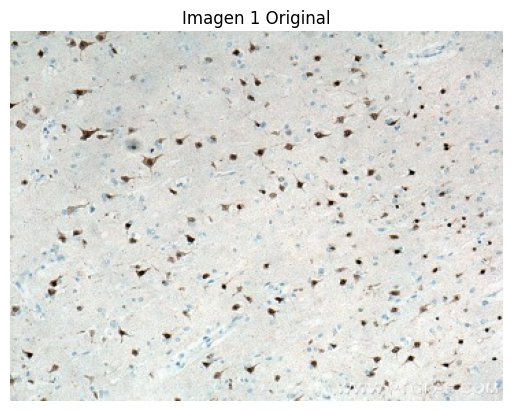

In [3]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Cargar la imagen
img = Image.open("image1.jpg")

# Convertir a array NumPy
img_np = np.array(img)

# Convertir de RGB a BGR (para usar con OpenCV)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Mostrar la imagen para confirmar la carga
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Imagen 1 Original")
plt.axis("off")
plt.show()


---
Una vez cargada la imagen, el primer paso que he realizado ha sido convertir el espacio de color de RGB a HSV, ya que este modelo separa la información de color (Hue y Saturation) de la intensidad luminosa (Value), lo que facilita el análisis. <p>
He decidido utilizar el canal V (Value) porque representa la intensidad o brillo de cada píxel, y en este caso las células marrones presentan un contraste más marcado respecto al fondo, lo que permite diferenciarlas con mayor claridad.

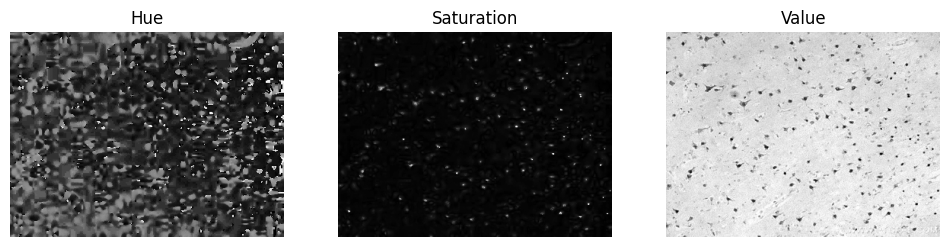

In [4]:
import cv2, matplotlib.pyplot as plt

hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)  # convertimos a HSV
h, s, v = cv2.split(hsv)  # separamos canales
fig, axes = plt.subplots(1, 3, figsize=(12,4))  # una fila, tres columnas
for ax, data, title in zip(axes, [h,s,v], ['Hue','Saturation','Value']):
    ax.imshow(data, cmap='gray')  # mostramos canal en escala de grises
    ax.set_title(title); ax.axis('off')  # quitamos ejes y ponemos título
plt.show()  # renderizamos en la misma línea


---
En este paso he aplicado una máscara binaria inversa sobre la imagen del canal V, con el objetivo de separar las regiones correspondientes a las células marrones del fondo.<p>
Para ello he utilizado un umbral de intensidad de 100, que define el límite a partir del cual un píxel se considera suficientemente oscuro para formar parte de una célula.<p>





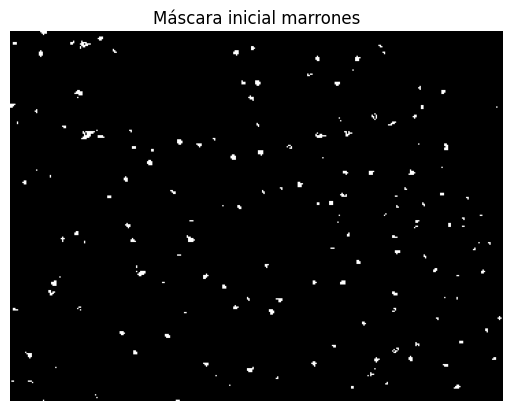

In [5]:
import cv2, matplotlib.pyplot as plt
_, mask = cv2.threshold(v, 100, 255, cv2.THRESH_BINARY_INV)  # invertimos: marrones=blanco

"""
El valor 255 representa la intensidad máxima posible en una imagen de 8 bits
y se asigna a los píxeles que cumplen la condición, haciendo que aparezcan en blanco sobre un fondo negro.
"""

plt.imshow(mask, cmap='gray'); plt.title('Máscara inicial marrones'); plt.axis('off')
plt.show()


---
Una vez obtenida la primera máscara, quería optimizar el valor del umbral para mejorar la segmentación.<p>
Para ello he generado un histograma del canal V, que representa en el eje X los niveles de intensidad (de 0 a 255) y en el eje Y la frecuencia de píxeles que presentan cada nivel.


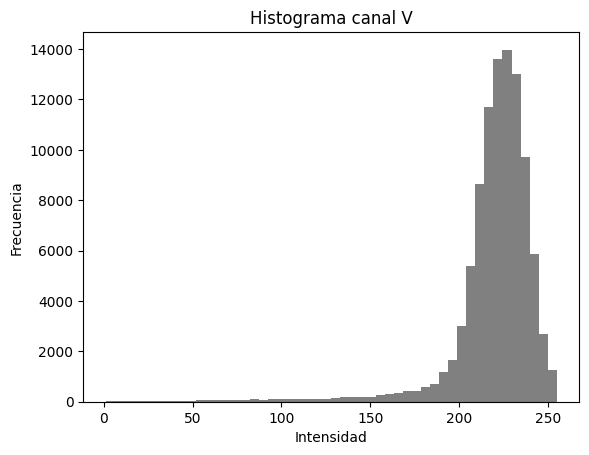

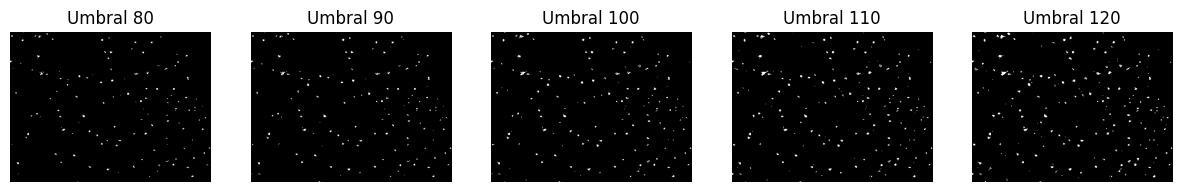

In [6]:
import cv2, numpy as np, matplotlib.pyplot as plt

vals = v.flatten()  # valores del canal V
plt.hist(vals, bins=50, color='gray')  # histograma de intensidades
plt.title('Histograma canal V'); plt.xlabel('Intensidad'); plt.ylabel('Frecuencia')
plt.show()

ths = [80, 90, 100, 110, 120]  # umbrales candidatos
fig, axes = plt.subplots(1, len(ths), figsize=(15,4))  # una fila
for ax, t in zip(axes, ths):
    _, mask_t = cv2.threshold(v, t, 255, cv2.THRESH_BINARY_INV)  # umbral binario invertido
    ax.imshow(mask_t, cmap='gray')  # mostramos resultado
    ax.set_title(f'Umbral {t}'); ax.axis('off')  # título + sin ejes
plt.show()


---
Al analizar el eje X del histograma, he podido decidir qué valor de umbral utilizar.

En este caso he elegido un umbral de 120, de modo que los píxeles con valores inferiores a este umbral corresponden a las regiones que me interesan.
Como en pasos anteriores había invertido la imagen, los valores claros representan las células marrones, por lo que al aplicar este umbral me quedo precisamente con esas zonas.

Células marrones detectadas (umbral 120): 214


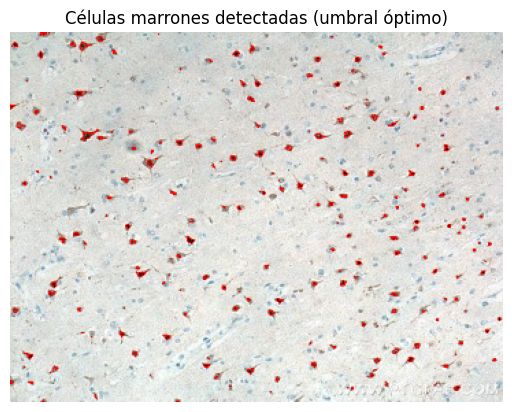

In [7]:
import cv2, matplotlib.pyplot as plt

_, mask_opt = cv2.threshold(v, 120, 255, cv2.THRESH_BINARY_INV)  # umbral óptimo
contours, _ = cv2.findContours(mask_opt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # contornos
img_final = img_cv.copy()  # copia original
cv2.drawContours(img_final, contours, -1, (0,0,255), 1)  # dibujamos en rojo
print("Células marrones detectadas (umbral 120):", len(contours))  # total
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.title('Células marrones detectadas (umbral óptimo)'); plt.show()


### 1.2 Elementos celulares (azul)

Una vez finalizado el conteo de las células marrones, he pasado a realizar el conteo de las células azules.

Inicialmente he probado a trabajar en el espacio de color CIE Lab, pero los resultados obtenidos no eran satisfactorios, ya que las células azules no se diferenciaban con claridad del fondo.

Por ello, he decidido finalmente mantener el espacio HSV, como en el caso anterior.

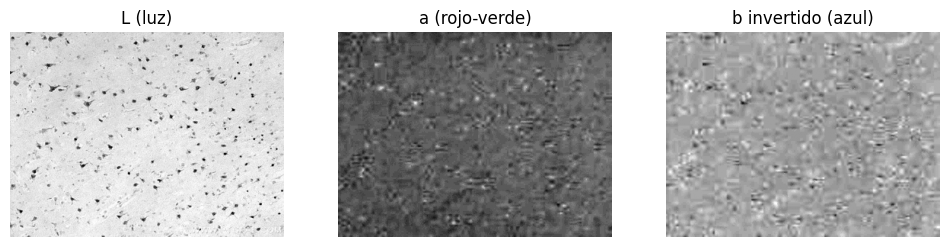

In [8]:
import cv2, matplotlib.pyplot as plt

lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)  # convertimos de BGR a Lab
L, a, b = cv2.split(lab)  # separamos canales
b_inv = cv2.bitwise_not(b)  # invertimos b* para que el azul sea claro (alto valor)
fig, axes = plt.subplots(1,3,figsize=(12,4))  # una fila
for ax, data, title in zip(axes, [L,a,b_inv], ['L (luz)','a (rojo-verde)','b invertido (azul)']):
    ax.imshow(data, cmap='gray'); ax.set_title(title); ax.axis('off')
plt.show()


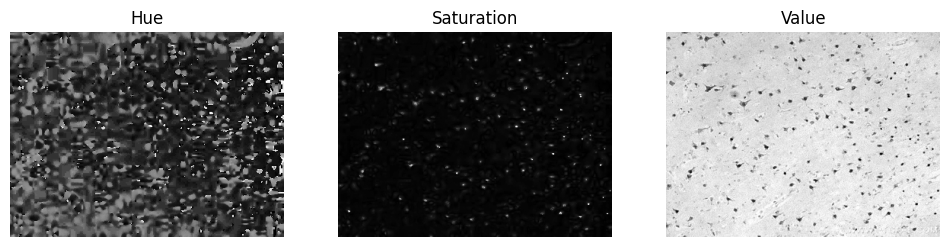

In [9]:
import cv2, matplotlib.pyplot as plt

hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)  # convertimos a HSV
h, s, v = cv2.split(hsv)  # separamos canales
fig, axes = plt.subplots(1,3,figsize=(12,4))
for ax, data, title in zip(axes, [h,s,v], ['Hue','Saturation','Value']):
    ax.imshow(data, cmap='gray'); ax.set_title(title); ax.axis('off')
plt.show()


---
En este caso he trabajado con el canal H (Hue) del espacio HSV.

El primer paso ha sido generar un histograma con los valores de este canal.
El objetivo de este histograma es analizar la distribución de tonos en la imagen y así poder identificar en qué rango de valores se encuentran las células azules.

De esta forma, puedo definir un rango de umbral adecuado para aislarlas del resto de la imagen y construir una máscara selectiva en los pasos posteriores.

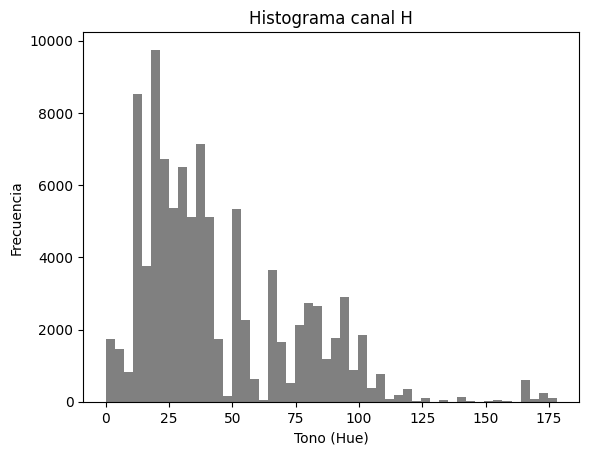

In [10]:
import cv2, matplotlib.pyplot as plt, numpy as np

plt.hist(h.flatten(), bins=50, color='gray')  # histograma canal H
plt.title('Histograma canal H'); plt.xlabel('Tono (Hue)'); plt.ylabel('Frecuencia')
plt.show()


---
A partir del histograma anterior he definido un rango de valores en el canal H comprendido entre 60 y 100, ya que este intervalo corresponde aproximadamente a los tonos azulados y cian dentro del espacio HSV.

He generado una máscara binaria que selecciona únicamente los píxeles cuyos tonos se encuentran dentro de este rango, de modo que las zonas blancas representan las posibles células azules y el fondo queda en negro.

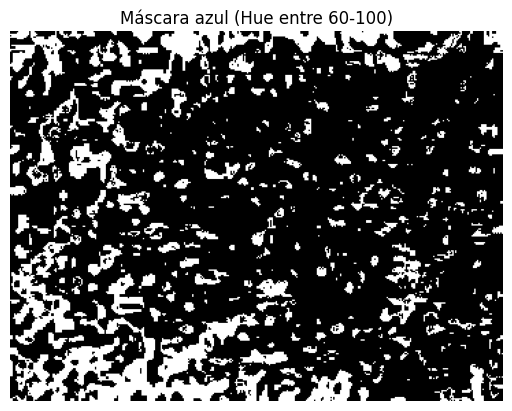

In [11]:
import cv2, matplotlib.pyplot as plt, numpy as np

# Rango aproximado de tonos azules en canal H
low_h, high_h = 60, 100
mask_blue_h = cv2.inRange(h, low_h, high_h)  # máscara binaria para esos tonos

plt.imshow(mask_blue_h, cmap='gray')
plt.title(f'Máscara azul (Hue entre {low_h}-{high_h})')
plt.axis('off')
plt.show()


---
Como el resultado anterior no era suficientemente preciso, he decidido ampliar el rango de tonos azules para incluir tonalidades más suaves.
Para ello he definido dos vectores en formato HSV:

`low_blue = [50, 10, 0]` indica el límite inferior del rango, donde el valor 50 representa el tono más verdoso dentro del azul, 10 la saturación mínima y 0 el valor más oscuro.

`high_blue = [110, 255, 255]` define el límite superior, donde el tono 110 cubre los azules más intensos y los valores máximos de saturación y brillo (255, 255) aseguran que se incluyan todas las intensidades de azul posibles.

De este modo, la nueva máscara genera una selección más amplia de píxeles azules, permitiendo detectar tanto las células de azul intenso como aquellas más claras o desaturadas.

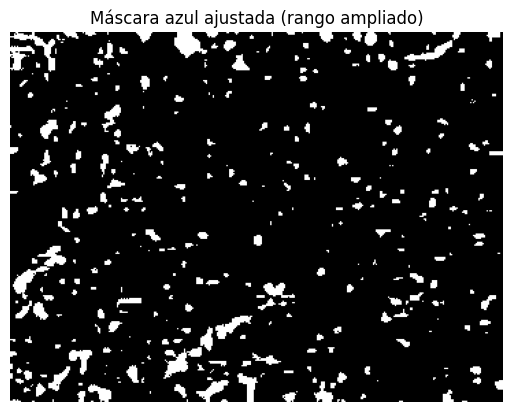

In [12]:
import cv2, numpy as np, matplotlib.pyplot as plt

# rangos más amplios (permitimos azules más suaves)
low_blue = np.array([50, 10, 0])
high_blue = np.array([110, 255, 255])

mask_blue_soft = cv2.inRange(hsv, low_blue, high_blue)  # nueva máscara
plt.imshow(mask_blue_soft, cmap='gray')
plt.title('Máscara azul ajustada (rango ampliado)')
plt.axis('off')
plt.show()


---
Finalmente, tras probar distintas combinaciones de canales, máscaras y rangos de valores, he decidido mantener este rango intermedio definido por `low_blue = [55, 15, 0]` y `high_blue = [105, 255, 255].`

Estos valores ofrecen un equilibrio adecuado entre detectar las células azules más visibles y evitar que el ruido o zonas no relevantes aparezcan en la máscara.
Con este ajuste, se consigue una segmentación más estable y representativa del conjunto de células azules presentes en la imagen.

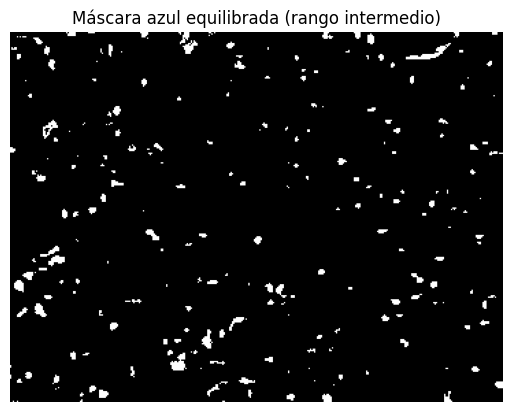

In [13]:
import cv2, numpy as np, matplotlib.pyplot as plt

# rango intermedio (equilibrio entre azul pálido y ruido)
low_blue = np.array([55, 15, 0])
high_blue = np.array([105, 255, 255])

mask_blue_eq = cv2.inRange(hsv, low_blue, high_blue)
plt.imshow(mask_blue_eq, cmap='gray')
plt.title('Máscara azul equilibrada (rango intermedio)')
plt.axis('off')
plt.show()


Células azules: 236


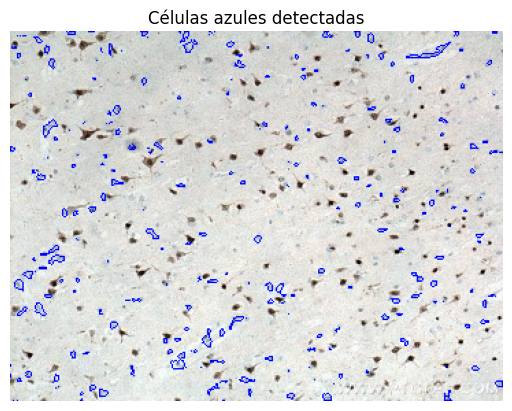

In [14]:
import cv2, matplotlib.pyplot as plt

contours, _ = cv2.findContours(mask_blue_eq, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # detectamos contornos
img_blue_detected = img_cv.copy()  # copia para dibujar
cv2.drawContours(img_blue_detected, contours, -1, (255,0,0), 1)  # dibujamos contornos en azul

count_blue = len(contours)  # número total de células
print("Células azules:", count_blue)  # mostramos el conteo

plt.imshow(cv2.cvtColor(img_blue_detected, cv2.COLOR_BGR2RGB))
plt.title('Células azules detectadas')
plt.axis('off')
plt.show()


### 1.3 Resultados finales

Una vez obtenidas las máscaras correspondientes a las células marrones y azules, he utilizado el método de contornos para realizar el recuento de cada tipo celular.

Este método busca bordes cerrados dentro de las regiones blancas de la máscara binaria, considerando cada contorno detectado como una célula individual.
De esta forma, se contabilizan todas las áreas conectadas que cumplen con las condiciones del umbral definido previamente.

Para facilitar la interpretación de los resultados, he superpuesto los contornos sobre la imagen original, dibujando en rojo los correspondientes a las células marrones y en azul los de las células azules.
Esto permite visualizar de forma comparativa la detección automática frente a la distribución real de las células en la imagen.

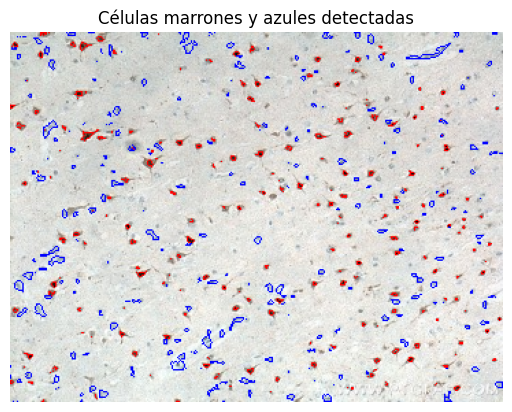

In [15]:
import cv2, matplotlib.pyplot as plt

img_final = img_cv.copy()  # copia base

# contornos marrones (usamos la máscara mask_opt)
cont_marr, _ = cv2.findContours(mask_opt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_final, cont_marr, -1, (0,0,255), 1)  # rojo

# contornos azules (usamos la máscara que elegiste, mask_blue_eq)
cont_azul, _ = cv2.findContours(mask_blue_eq, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_final, cont_azul, -1, (255,0,0), 1)  # azul

plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.title('Células marrones y azules detectadas')
plt.axis('off')
plt.show()


In [16]:
# contamos células marrones y azules
n_marr = len(cont_marr)
n_azul = len(cont_azul)
total = n_marr + n_azul

# calculamos porcentajes
p_marr = (n_marr / total) * 100
p_azul = (n_azul / total) * 100

print(f"Células marrones: {n_marr}")
print(f"Células azules: {n_azul}")
print(f"Total: {total}")
print(f"Porcentaje marrones: {p_marr:.1f}%")
print(f"Porcentaje azules: {p_azul:.1f}%")


Células marrones: 214
Células azules: 236
Total: 450
Porcentaje marrones: 47.6%
Porcentaje azules: 52.4%


En los resultados finales se observa que tanto las células marrones como las células azules han sido detectadas con un nivel de precisión aceptable.
La detección de las células marrones ha resultado más precisa, ya que en la imagen original presentaban un mayor contraste con el fondo y, por tanto, eran más sencillas de segmentar. En cambio, las células azules mostraban tonalidades más suaves, lo que ha dificultado su identificación en algunos casos.

Pese a ello, el método permite distinguir correctamente la mayoría de las células, aunque existen falsos negativos (células no detectadas) y falsos positivos (regiones detectadas donde no hay células reales).

Tras probar diferentes enfoques, canales de color y rangos de umbral, considero que el resultado obtenido es satisfactorio y representa un equilibrio adecuado entre precisión y simplicidad del procesamiento.

# IMAGEN 2

La segunda imagen analizada corresponde a una muestra de células de piel humana, por lo que solo existe un tipo de célula en la imagen.

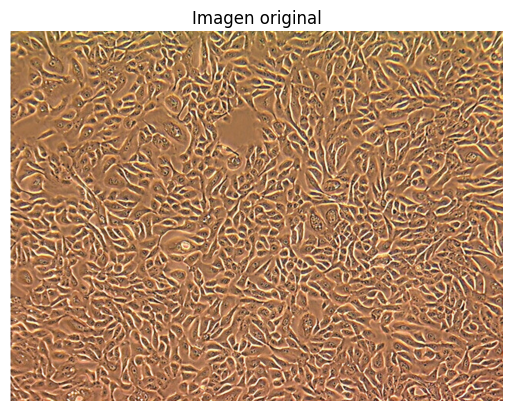

In [17]:
import cv2  # librería de visión por computador
import matplotlib.pyplot as plt  # para mostrar imágenes

img = cv2.imread('/content/image2.jpg')  # leer imagen original
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convertir de BGR a RGB
plt.imshow(img_rgb)  # mostrar imagen
plt.title('Imagen original')  # título descriptivo
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar


---
Después de cargar la imagen original, convertí el formato RGB a escala de grises. Realicé este paso para simplificar la información de la imagen, reduciendo los tres canales de color a un único canal de intensidad.

Probé diferentes opciones, pero comprobé que trabajar en escala de grises ofrecía un mayor contraste entre las células y el fondo, lo que facilitó los pasos posteriores de segmentación y conteo.

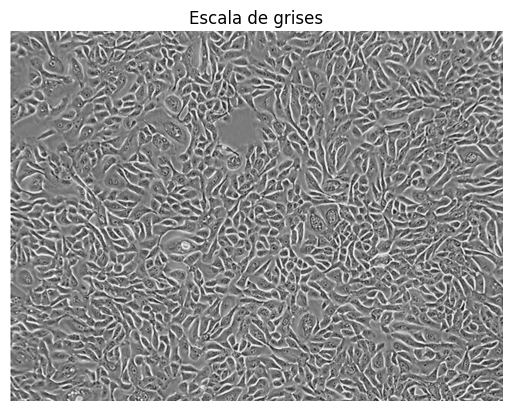

In [18]:
import cv2  # librería de visión artificial
import matplotlib.pyplot as plt  # para visualizar

# Use the already downloaded image2.jpg
img = cv2.imread('/content/image2.jpg')  # leer imagen
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convertir a escala de grises
plt.imshow(gray, cmap='gray')  # mostrar la imagen en grises
plt.title('Escala de grises')  # título
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar

In [19]:
print(gray.dtype, gray.min(), gray.max())

uint8 1 255


---
A continuación, apliqué una ecualización del histograma sobre la imagen en escala de grises. Este proceso ajusta la distribución de los niveles de intensidad, aumentando el contraste global y haciendo que las diferencias entre las células y el fondo sean más evidentes.

Una vez mejorado el contraste, utilicé un umbral adaptativo (Adaptive Threshold) para convertir la imagen en binaria, este método calcula el umbral de forma local. Invertí el resultado para representar las células en blanco sobre un fondo negro, lo que facilita su posterior análisis y segmentación.

Por último, apliqué una operación morfológica de apertura (morphological opening) con un kernel elíptico de tamaño (3,3) y una iteración, con el objetivo de eliminar el ruido fino y pequeñas imperfecciones sin afectar la forma real de las células.

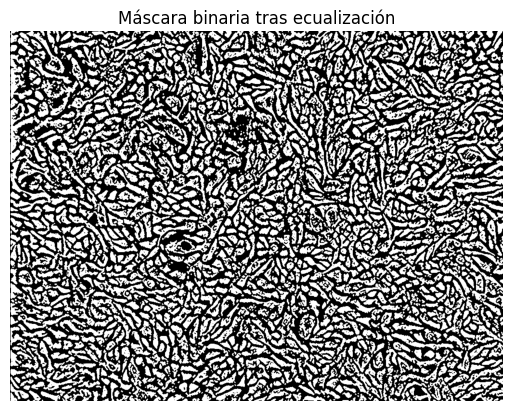

In [20]:
eq = cv2.equalizeHist(gray)  # mejorar contraste global
mask = cv2.adaptiveThreshold(eq, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                             cv2.THRESH_BINARY_INV, 31, 5)  # umbral local invertido
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))  # elemento morfológico
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)  # limpiar ruido fino
plt.imshow(mask, cmap='gray')  # mostrar resultado
plt.title('Máscara binaria tras ecualización')  # título
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar


---
Después de obtener la máscara binaria, observé que aún había regiones pequeñas que no correspondían a células reales. Para mejorar el resultado, utilicé la función `regionprops()` de *scikit-image*, que permite extraer propiedades geométricas de cada región conectada en la imagen, como el área, el perímetro o el centroide.

A partir de esta información, calculé el área de cada célula y ordené las regiones de mayor a menor tamaño. Posteriormente, seleccioné las 1000 células más grandes, eliminando aquellas de tamaño muy reducido que probablemente correspondían a ruido o fragmentos incompletos.

Con las etiquetas de las regiones seleccionadas, generé una nueva máscara binaria que muestra únicamente las células de mayor tamaño, lo que permitió mejorar la calidad del conjunto de datos.

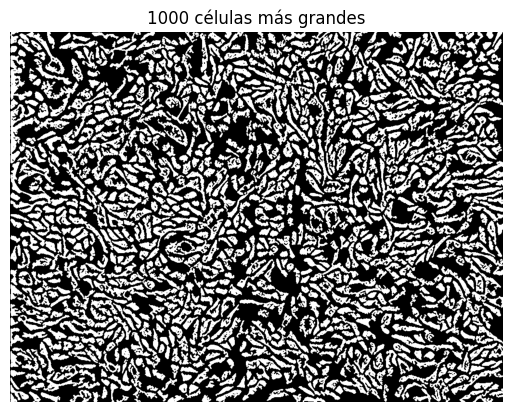

In [21]:
from skimage.measure import label, regionprops  # etiquetado y propiedades
import numpy as np
import matplotlib.pyplot as plt

label_img = label(mask)  # etiquetar regiones conectadas
props = regionprops(label_img)  # obtener propiedades de cada región
areas = [(p.area, p.label) for p in props]  # lista de áreas y etiquetas
areas.sort(reverse=True)  # ordenar por área descendente
labels_keep = [l for _, l in areas[:1000]]  # quedarnos con las 1000 mayores
mask_filtered = np.isin(label_img, labels_keep).astype(np.uint8) * 255  # generar nueva máscara
plt.imshow(mask_filtered, cmap='gray')  # mostrar resultado
plt.title('1000 células más grandes')  # título
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar


---
Tras seleccionar las 1000 células más grandes, quise comprobar si este número era adecuado o si podía optimizarlo. Para ello, representé un histograma de las áreas obtenidas con la función `regionprops()`.

Cada barra del histograma indica la frecuencia de aparición de un determinado rango de tamaños. Al observar la gráfica, vi que la mayoría de las regiones presentaban áreas muy pequeñas (inferiores a unos 150–200 píxeles), lo que corresponde principalmente a ruido o fragmentos celulares.

Este análisis me permitió definir un umbral de área mínima más preciso, manteniendo solo las regiones que realmente correspondían a células completas y descartando las más pequeñas.

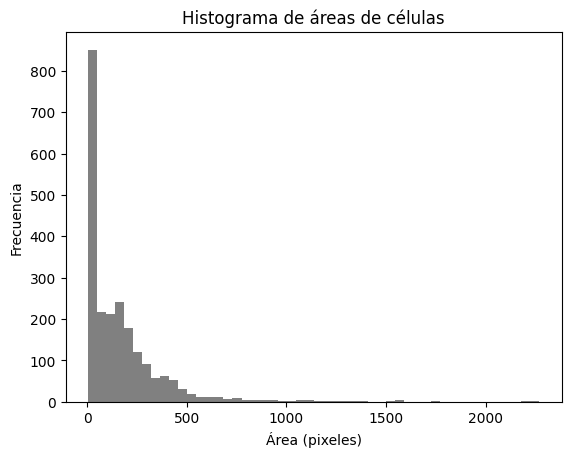

In [22]:
from skimage.measure import label, regionprops  # etiquetar regiones
import matplotlib.pyplot as plt

label_img = label(mask)  # etiquetar regiones conectadas
props = regionprops(label_img)  # obtener propiedades
areas = [p.area for p in props]  # extraer áreas individuales
plt.hist(areas, bins=50, color='gray')  # graficar histograma con 50 bins
plt.title('Histograma de áreas de células')  # título
plt.xlabel('Área (pixeles)')  # eje x
plt.ylabel('Frecuencia')  # eje y
plt.show()  # visualizar


---
A partir del análisis del histograma, determiné que la mayoría del ruido correspondía a regiones con un área inferior a 150 píxeles cuadrados. Por ello, establecí ese valor como umbral mínimo de área para refinar la segmentación.

Utilicé nuevamente la información obtenida con regionprops() para recorrer todas las regiones etiquetadas y conservar únicamente aquellas cuyo área era mayor o igual a este valor. De esta forma, generé una máscara optimizada.

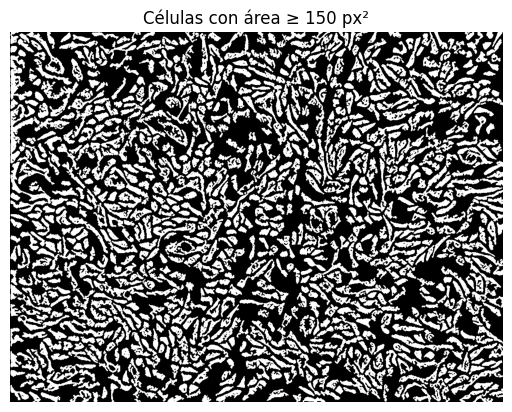

In [23]:
min_area = 150  # umbral estimado por histograma
label_img = label(mask)  # etiquetar regiones
props = regionprops(label_img)
mask_filtered = np.zeros_like(mask)  # crear máscara vacía
for p in props:
    if p.area >= min_area:  # mantener solo las grandes
        mask_filtered[label_img == p.label] = 255
plt.imshow(mask_filtered, cmap='gray')
plt.title(f'Células con área ≥ {min_area} px²')
plt.axis('off')
plt.show()


---
Una vez obtenida la máscara optimizada, procedí a realizar el conteo automático de las células. Para ello utilicé la función `connectedComponents()` de OpenCV, que identifica todas las regiones conectadas de píxeles blancos en la máscara binaria.

Esta función me devolvió el número total de regiones detectadas y una matriz de etiquetas, donde cada célula recibe un identificador distinto. Posteriormente normalicé estas etiquetas y apliqué un mapa de color tipo JET, de modo que cada célula se visualizara con un color diferente.

De esta manera, pude comprobar visualmente la segmentación y obtener el número total de células detectadas.

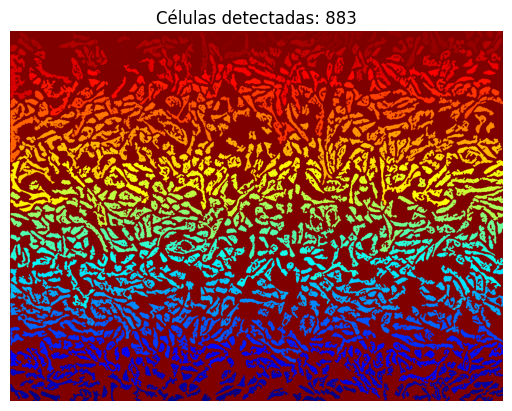

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

num_labels, labels = cv2.connectedComponents(mask_filtered)  # etiquetar regiones
label_viz = np.uint8(255 * labels / np.max(labels))  # Normaliza los valores de las etiquetas para poder representarlos gráficamente en el rango de 0 a 255.
color_map = cv2.applyColorMap(label_viz, cv2.COLORMAP_JET)  # aplicar mapa de color
plt.imshow(color_map)  # mostrar imagen coloreada
plt.title(f'Células detectadas: {num_labels - 1}')  # mostrar conteo en título
#se resta 1 region ya que esta es el fondo
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar


---
Utilicé la función `label()` para asignar un identificador único a cada región conectada de la máscara binaria final.

A continuación, convertí la imagen a formato color para poder superponer texto y, con la ayuda de `regionprops()`, calculé el centroide de cada célula. En esa posición escribí el número correspondiente utilizando la función `putText()` de OpenCV, de modo que cada célula quedó identificada en color verde.

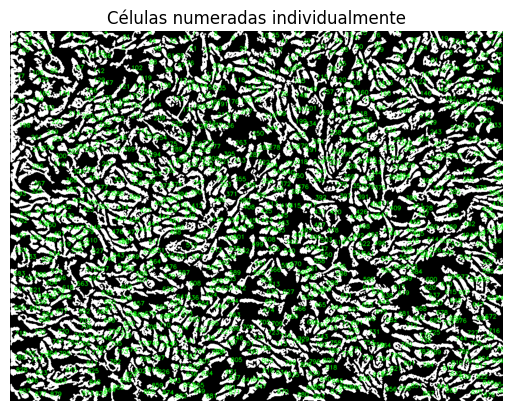

In [25]:
from skimage.measure import label, regionprops  # medir propiedades
import matplotlib.pyplot as plt
import cv2

label_img = label(mask_filtered)  # etiquetar células
img_color = cv2.cvtColor(mask_filtered, cv2.COLOR_GRAY2BGR)  # pasar a color

for i, p in enumerate(regionprops(label_img), start=1):  # recorrer cada célula
    y, x = map(int, p.centroid)  # coordenadas del centroide
    cv2.putText(img_color, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                0.4, (0, 255, 0), 1, cv2.LINE_AA)  # escribir número

plt.imshow(img_color[..., ::-1])  # mostrar en RGB
plt.title('Células numeradas individualmente')  # título descriptivo
plt.axis('off')  # ocultar ejes
plt.show()  # visualizar


---
Para validar visualmente la segmentación y el conteo de células, compararé los resultados obtenidos con la imagen original. Para ello, generé dos visualizaciones finales: una con las células numeradas y otra con sus contornos delineados.

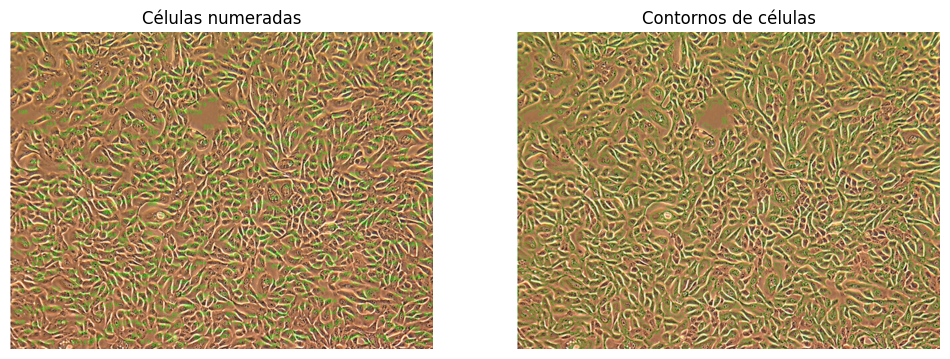

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops

# cargar y preparar imagen original
orig = cv2.imread('/content/image2.jpg')
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# preparar etiquetas
label_img = label(mask_filtered)

# ----- imagen con números -----
overlay_num = orig.copy()
for i, p in enumerate(regionprops(label_img), start=1):
    y, x = map(int, p.centroid)
    cv2.putText(overlay_num, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                0.4, (0, 255, 0), 1, cv2.LINE_AA)
superposed_num = cv2.addWeighted(overlay_num, 0.6, orig, 0.4, 0)

# ----- imagen con contornos -----
overlay_cont = orig.copy()
contours, _ = cv2.findContours(mask_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay_cont, contours, -1, (0, 255, 0), 1)
superposed_cont = cv2.addWeighted(overlay_cont, 0.6, orig, 0.4, 0)

# mostrar ambas imágenes en la misma salida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(superposed_num)
plt.title('Células numeradas')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superposed_cont)
plt.title('Contornos de células')
plt.axis('off')

plt.show()


Tras realizar todo el proceso de análisis y segmentación de la imagen, probé previamente distintos métodos alternativos, como la aplicación de filtros de desenfoque (blur), operaciones morfológicas de dilatación para engrosar los bordes, o transformaciones como close con diferentes tamaños de kernel e iteraciones. También experimenté con técnicas más avanzadas como Distance Transform y Watershed, aunque ninguna de ellas ofreció resultados satisfactorios en este caso.

Finalmente, el método que seguí permitió obtener un resultado bastante decente, aunque no perfecto. Pude detectar correctamente la mayoría de las células, aunque en algunas zonas donde estas se encuentran muy agrupadas, la segmentación no es del todo precisa. De igual modo, en otras regiones el algoritmo detecta falsos positivos, identificando como células áreas donde realmente no las hay.

Aun con estas limitaciones, considero que el resultado global es adecuado y representa una detección coherente y funcional, especialmente teniendo en cuenta la complejidad del patrón celular presente en la imagen.